In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import matplotlib.pyplot as plt
import matplotlib as mpl


import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [2]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds['analysed_sst'] = ds.analysed_sst - 273.15
ds

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 251, lon: 234)
Coordinates:
  * lat               (lat) float32 33.0 33.06 33.12 33.18 ... 47.88 47.94 48.0
  * lon               (lon) float32 -132.0 -131.9 -131.9 ... -118.1 -118.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 16.6 16.56 16.52 ... nan nan nan
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [3]:
#Get the selected data as a reference 2002-2012 data
test = ds.sel(time=slice('2002-06-01', '2012-12-31'))
test

<xarray.Dataset>
Dimensions:           (time: 3867, lat: 251, lon: 234)
Coordinates:
  * lat               (lat) float32 33.0 33.06 33.12 33.18 ... 47.88 47.94 48.0
  * lon               (lon) float32 -132.0 -131.9 -131.9 ... -118.1 -118.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2012-12-3...
Data variables:
    analysed_sst      (time, lat, lon) float32 16.6 16.56 16.52 ... nan nan nan
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [4]:
#calculating the mean and sd
test_mean = test.analysed_sst.groupby('time.month').mean()
test_sd = test.analysed_sst.groupby('time.month').std()

In [5]:
#segmenting the dataset based on year
ds_2014 = ds.sel(time=slice('2014-01-01', '2014-12-31'))
ds_2015 = ds.sel(time=slice('2015-01-01', '2015-12-31'))
ds_2016 = ds.sel(time=slice('2016-01-01', '2016-09-30'))

In [6]:
#calculate the means for each month for each selected year
ds_2014m = ds_2014.analysed_sst.groupby('time.month').mean()
ds_2015m = ds_2015.analysed_sst.groupby('time.month').mean()
ds_2016m = ds_2016.analysed_sst.groupby('time.month').mean()

In [7]:
diff_2014 = ds_2014m - test_mean
diff_2015 = ds_2015m - test_mean
diff_2016 = ds_2016m - test_mean

sd_2014 = diff_2014 / test_sd
sd_2015 = diff_2015 / test_sd
sd_2016 = diff_2016 / test_sd

In [8]:
#check
sd_2014.coords

Coordinates:
  * lat      (lat) float32 33.0 33.06 33.12 33.18 ... 47.82 47.88 47.94 48.0
  * lon      (lon) float32 -132.0 -131.9 -131.9 -131.8 ... -118.1 -118.1 -118.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

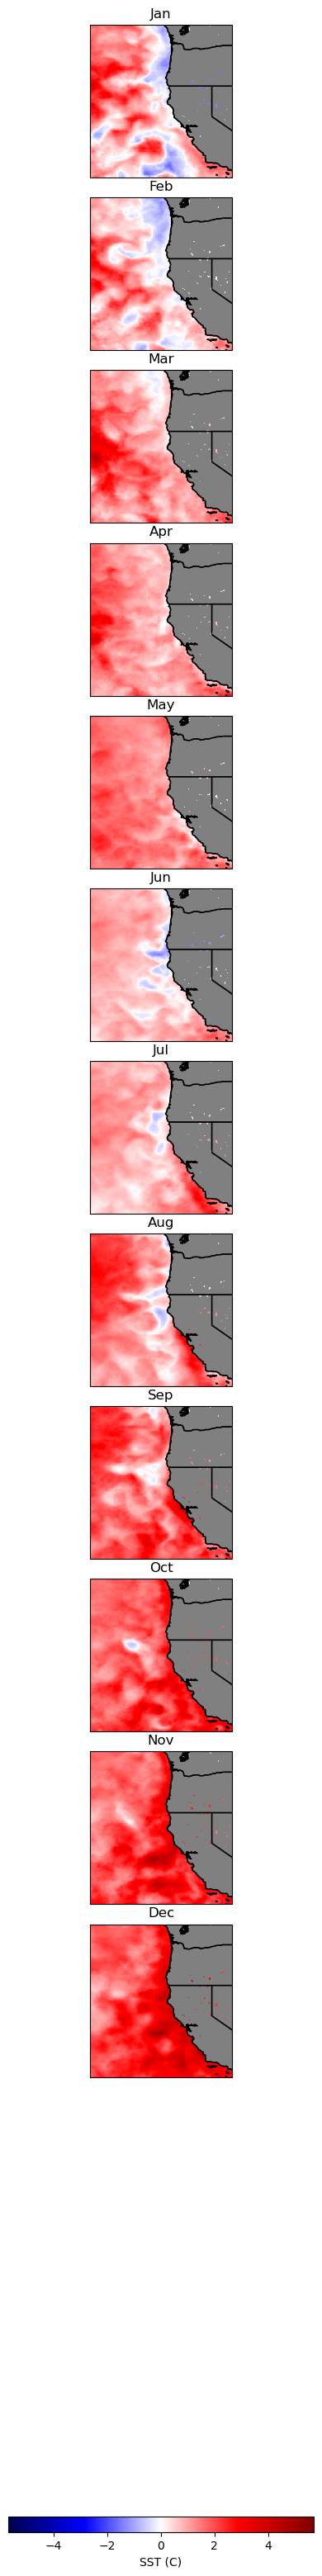

In [9]:
p = sd_2014.plot(col='month', x = 'lon', y = 'lat', col_wrap=1, transform=ccrs.PlateCarree(),
                            #vmin=-3, vmax=3,
                            cmap="seismic",
                            subplot_kws={'projection': ccrs.PlateCarree()},
                            cbar_kwargs={'orientation': 'horizontal', 'label' : 'SST (C)'});

titles = ['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for ax, title in zip(p.axes.flatten(), titles):
    ax.set_title(title, fontsize=12)

for ax in p.axes.flat:
    ax.add_feature(cfeature.BORDERS)
    ax.coastlines("10m", color="k")
    ax.add_feature(cfeature.LAND, color="grey")
    ax.add_feature(cfeature.STATES.with_scale("10m"))

In [10]:
#why is colorplot so far down??
#change month to overlays and year at the top
#add the x and y variables back
#why is the plot wrong- look at numbers??
#custom colorplot, not a gradient- more discrete